# **NOTES**
* This file is a copy of mvp_model.ipynb with some changes (each done separately!)
* Features RobustScaled (=> leads to worse results)
* Features MinMax Scaled (=> leads to worse results)
* Sales moving average has been removed from the pipeline (=> leads to worse results)

# Imports

In [1230]:


import pandas as pd
import numpy as np
import random

from mamimo.time_utils import add_time_features, PowerTrend
from mamimo.carryover import ExponentialCarryover
from mamimo.saturation import ExponentialSaturation, BoxCoxSaturation

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor

import holidays

import seaborn as sns
import matplotlib.pyplot as plt

# Load DataFrame

In [1231]:
df = pd.read_csv('../../raw_data/df.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
df['day'] = df.index # we will use this in our column transformer
df = df.drop(columns = ['fb_impressions', 'fb_clicks', 'google_impressions', 'google_clicks', 'tt_impressions', 'tt_clicks'])

# Split Data

In [1232]:

n_splits = 5  # Number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(df):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

train_df = train_df.assign(trend=range(len(train_df)))

y_train = train_df['total_sales']
X_train = train_df.drop(columns = ['total_sales', 'orders'])

test_df = test_df.assign(trend=range(len(test_df)))

y_test = test_df['total_sales']
X_test = test_df.drop(columns = ['total_sales', 'orders'])

In [1233]:
train_df

,orders,total_sales,facebook,google,tiktok,day,trend
Day,,,,,,,
2021-07-01,10,414.85,257.01,1.17,0.00,2021-07-01,0
2021-07-02,6,229.95,250.30,0.84,0.00,2021-07-02,1
2021-07-03,10,459.89,248.59,0.72,0.00,2021-07-03,2
2021-07-04,17,508.36,258.05,0.07,0.00,2021-07-04,3
2021-07-05,13,399.88,257.47,0.38,0.00,2021-07-05,4
...,...,...,...,...,...,...,...
2023-04-12,83,3718.12,885.33,208.52,209.03,2023-04-12,650
2023-04-13,75,2913.63,882.17,186.47,208.82,2023-04-13,651
2023-04-14,53,1735.46,662.08,160.69,216.38,2023-04-14,652


# Baseline Model

In [1234]:
baseline = train_df.shift(1) # baseline['total_sales'] is equivalent to y_pred

y_pred = baseline['total_sales']
y_true = train_df['total_sales']

# MSE
mse = ((y_true - y_pred) ** 2).mean()

# Calculate TSS (Total Sum of Squares)
mean_y_true = np.mean(y_true)
tss = np.sum((y_true - mean_y_true)**2)

# Calculate RSS (Residual Sum of Squares)
rss = np.sum((y_true - y_pred)**2)

# Calculate R-squared (Coefficient of Determination)
r_squared = 1 - (rss / tss)

f"{mse} is our MSE to beat; {r_squared} is our R squared to beat!"

'595453.442743578 is our MSE to beat; 0.6398209085770498 is our R squared to beat!'

# Check for stationarity

In [1235]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df.total_sales)[1] # close enough to 0.05, so our data is stationary enough

0.062198848540433505

# Create Custom Tranformers

## Time Features

### Holidays

In [1236]:
class AddHolidaysTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        de_holiday_list = []
        for holiday in holidays.Germany(years=[2021,2022,2023]).items():
            de_holiday_list.append(holiday)
        de_holidays_df = pd.DataFrame(de_holiday_list, columns=["date", "holiday"])
        de_holidays_df['date'] = pd.to_datetime(de_holidays_df['date'])
        de_holidays_df.set_index('date', inplace=True)
        
        at_holiday_list = []
        for holiday in holidays.Austria(years=[2021,2022,2023]).items():
            at_holiday_list.append(holiday)
        at_holidays_df = pd.DataFrame(at_holiday_list, columns=["date", "holiday"])
        at_holidays_df['date'] = pd.to_datetime(at_holidays_df['date'])
        at_holidays_df.set_index('date', inplace=True)

        # add DE holidays to df
        merged_df = df.merge(de_holidays_df, how='left', left_index=True, right_index=True)
        merged_df['de_holiday'] = merged_df.index.isin(de_holidays_df.index).astype(int)
        merged_df.drop(columns=['holiday'], inplace=True)
        
        # add AT holidays to df
        at_holidays_df['at_holiday'] = 1 # add a 1 column to austrian holidays dataframe to help us merge with DE holidays
        merged_df = merged_df.merge(at_holidays_df[['at_holiday']], how='left', left_index=True, right_index=True)
        merged_df.head() # creates two columns (at_holiday_x, at_holiday_y), we only need one
        merged_df['at_holiday'].fillna(0, inplace=True) # replace NaN (no holiday) with 0
        merged_df['at_holiday'] = merged_df['at_holiday'].astype(int) # convert 1 and 0 to integers
        
        # combine columns
        merged_df['holiday'] = (merged_df['at_holiday'] | merged_df['de_holiday']).astype(int)
        merged_df = merged_df.drop(columns = ['de_holiday', 'at_holiday']) # drop individual DE and AT rows
        
        return merged_df[['holiday']]#.reset_index(drop=True)


#### Does it work?

In [1237]:
holidays_transformer = AddHolidaysTransformer()
df = train_df.copy()
holidays_transformer.fit_transform(df)

,holiday
Day,
2021-07-01,0
2021-07-02,0
2021-07-03,0
2021-07-04,0
2021-07-05,0
...,...
2023-04-12,0
2023-04-13,0
2023-04-14,0


#### Yes!

### Weekends

In [1238]:
class AddWeekendsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        weekday_values = df.index.weekday
        df['fri_sat'] = ((weekday_values == 4) | (weekday_values == 5)).astype(int)
        return df[['fri_sat']]

#### Does it work?

In [1239]:
weekends_transformer = AddWeekendsTransformer()
df = train_df.copy()
weekends_transformer.fit_transform(df)

,fri_sat
Day,
2021-07-01,0
2021-07-02,1
2021-07-03,1
2021-07-04,0
2021-07-05,0
...,...
2023-04-12,0
2023-04-13,0
2023-04-14,1


#### Yes!

### Cyclical months

In [1240]:
class AddMonthsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, power=1):
        self.power = power
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df = (df
        .pipe(add_time_features, month=True) 
        )
        
        months_in_a_year = 12
        df['sin_MonthYear'] = np.sin(2*np.pi*(df['month'])/months_in_a_year)
        df['cos_MonthYear'] = np.cos(2*np.pi*(df['month'])/months_in_a_year)
        df.drop(columns=['month'], inplace=True)
        
        return df[['sin_MonthYear', 'cos_MonthYear']]

#### Does it work?

In [1241]:
add_months_transformer = AddMonthsTransformer()
df = train_df.copy()
add_months_transformer.fit_transform(df)

,sin_MonthYear,cos_MonthYear
Day,,
2021-07-01,-0.500000,-0.866025
2021-07-02,-0.500000,-0.866025
2021-07-03,-0.500000,-0.866025
2021-07-04,-0.500000,-0.866025
2021-07-05,-0.500000,-0.866025
...,...,...
2023-04-12,0.866025,-0.500000
2023-04-13,0.866025,-0.500000
2023-04-14,0.866025,-0.500000


#### Yes!

### Power Trend

In [1242]:
class AddTrendTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, power=1):
        self.power = power
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly

        df['trend'] = PowerTrend(self.power).fit_transform(df[['trend']])
        
        return df[['trend']]

#### Does it work?

In [1243]:
add_trend_transformer = AddTrendTransformer(power = 1)
df = train_df.copy()
add_trend_transformer.fit_transform(df)

,trend
Day,
2021-07-01,0
2021-07-02,1
2021-07-03,2
2021-07-04,3
2021-07-05,4
...,...
2023-04-12,650
2023-04-13,651
2023-04-14,652


#### Yes!

## Sales Features

### Lag

In [1244]:
df = train_df.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
df['sales_lag'] = df['total_sales'].shift(1)
df

,orders,total_sales,facebook,google,tiktok,day,trend,sales_lag
Day,,,,,,,,
2021-07-01,10,414.85,257.01,1.17,0.00,2021-07-01,0,NaN
2021-07-02,6,229.95,250.30,0.84,0.00,2021-07-02,1,414.85
2021-07-03,10,459.89,248.59,0.72,0.00,2021-07-03,2,229.95
2021-07-04,17,508.36,258.05,0.07,0.00,2021-07-04,3,459.89
2021-07-05,13,399.88,257.47,0.38,0.00,2021-07-05,4,508.36
...,...,...,...,...,...,...,...,...
2023-04-12,83,3718.12,885.33,208.52,209.03,2023-04-12,650,4443.77
2023-04-13,75,2913.63,882.17,186.47,208.82,2023-04-13,651,3718.12
2023-04-14,53,1735.46,662.08,160.69,216.38,2023-04-14,652,2913.63


In [1245]:
class AddSalesLagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=7):
        self.period = period

    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Adds a sales lag column with the specified period."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df['sales_lag'] = df['total_sales'].shift(self.period)
        df['sales_lag'] = df['sales_lag'].bfill()  # Backfill missing values
        return df[['sales_lag']]


In [1246]:
sales_lag_transformer = AddSalesLagTransformer(period = 1)
df = train_df.copy()
sales_lag_transformer.fit_transform(df)

,sales_lag
Day,
2021-07-01,414.85
2021-07-02,414.85
2021-07-03,229.95
2021-07-04,459.89
2021-07-05,508.36
...,...
2023-04-12,4443.77
2023-04-13,3718.12
2023-04-14,2913.63


### Moving Average

In [1247]:

class AddSalesMovAvgTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=7):
        self.window_size = window_size

    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Adds a sales moving average column. Indicate the window size (default = 7)"""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df['sales_lag'] = df['total_sales'].shift(1)
        df['sales_moving_avg'] = df['sales_lag'].rolling(window=self.window_size, center=False).mean()
        df['sales_moving_avg'] = df['sales_moving_avg'].bfill()  # Backfill missing values at beginning of df
        #df['sales_moving_avg'] = df['sales_moving_avg'].ffill()  # Forwardfill missing values at end of df
        return df[['sales_moving_avg']]

#### Does it work?

In [1248]:
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 2)
df = train_df.copy()
sales_mov_avg_transformer.fit_transform(df)

,sales_moving_avg
Day,
2021-07-01,322.400
2021-07-02,322.400
2021-07-03,322.400
2021-07-04,344.920
2021-07-05,484.125
...,...
2023-04-12,4663.250
2023-04-13,4080.945
2023-04-14,3315.875


#### Yes!

### Exponential Smoothing

In [1249]:
class AddSalesExpSmoothingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha = 0.5, shift = 1):
        self.alpha = alpha
        self.shift = shift
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Adds a sales (exponential smoothing) column. Indicate the alpha value (default = 0.5)"""
        df = X.copy()
        df = sales_lag_transformer.fit_transform(df)
        #df['sales_lag_'] = df['total_sales'].shift(self.shift)
        smoothed_series = [df['sales_lag'].iloc[0]]
        smoothed_series[0] = df['sales_lag'][0]
        
        for i in range(1, len(df)):
            smoothed_value = self.alpha * df['sales_lag'].iloc[i] + (1 - self.alpha) * smoothed_series[-1]
            smoothed_series.append(smoothed_value)
        df['smoothed_sales'] = smoothed_series
        return df[['smoothed_sales']]

#### Does it work?

In [1250]:
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)
df = train_df.copy()

sales_exp_smoothing_transformer.fit_transform(df)

,smoothed_sales
Day,
2021-07-01,414.850000
2021-07-02,414.850000
2021-07-03,322.400000
2021-07-04,391.145000
2021-07-05,449.752500
...,...
2023-04-12,3972.187023
2023-04-13,3845.153512
2023-04-14,3379.391756


#### Yes!

## Adstock
* comes from `mamimo` package, explained [here](https://towardsdatascience.com/an-upgraded-marketing-mix-modeling-in-python-5ebb3bddc1b6)

In [1251]:
adstock = ColumnTransformer(
    [
     ('facebook_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', BoxCoxSaturation())
     ]), ['facebook']),
     ('google_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', BoxCoxSaturation())
     ]), ['google']),
     ('tiktok_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', BoxCoxSaturation())
     ]), ['tiktok'])
])

def create_df(array: np.array):
    columns = ['orders', 'total_sales', 'facebook', 'google', 'tiktok', 'holiday',
       'fri_sat', 'sin_MonthYear', 'cos_MonthYear',
       'google_cumulative', 'tiktok_cumulative', 'facebook_cumulative',
       'sales_lag', 'sales_moving_avg']
    columns_ = ['facebook','google','tiktok']
    df = pd.DataFrame(array, columns = columns_)
    datetime_series = pd.Series(
        pd.date_range("2021-07-01", periods=len(df), freq="D")
        )
    df = pd.concat([df,datetime_series],axis=1)
    df = df.set_index(0)
    df = df.rename(index={0: 'Day'})
    df = df[['adstock_fb', 'adstock_gg', 'adstock_tt']]
    return df#[['adstock_fb', 'adstock_gg', 'adstock_tt']]

In [1252]:
df = train_df.copy()
df = pd.DataFrame(adstock.fit_transform(df))
df.columns = ['adstock_fb', 'adstock_gg', 'adstock_tt']
df

,adstock_fb,adstock_gg,adstock_tt
0,257.01,1.17,0.00
1,250.30,0.84,0.00
2,248.59,0.72,0.00
3,258.05,0.07,0.00
4,257.47,0.38,0.00
...,...,...,...
650,885.33,208.52,209.03
651,882.17,186.47,208.82
652,662.08,160.69,216.38
653,481.71,149.16,239.65


# Instantiate Custom Transformers

In [1253]:

holidays_transformer = AddHolidaysTransformer()
weekends_transformer = AddWeekendsTransformer()
add_months_transformer = AddMonthsTransformer()
cum_spending_FB_transformer = AddCumSpendingFBTransformer(period = 'weekly', carryover = False)
cum_spending_GG_transformer = AddCumSpendingGGTransformer(period = 'weekly', carryover = False)
cum_spending_TT_transformer = AddCumSpendingTTTransformer(period = 'weekly', carryover = False)
sales_lag_transformer = AddSalesLagTransformer(period = 7)
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 7)
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)

# Debug CT

## Time CT

In [1254]:
time_features = ColumnTransformer(
    [
     ('holidays_pipe', Pipeline([
            ('add_holidays', AddHolidaysTransformer())
     ]), ['day']),
     ('weekends_pipe', Pipeline([
            ('add_weekends', AddWeekendsTransformer())
     ]), ['day']),
     ('months_pipe', Pipeline([
            ('add_months', AddMonthsTransformer())
     ]), ['day'])
])

In [1255]:
df = train_df.copy()
transformed_df = time_features.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df, columns = ['holiday', 'weekends', 'sin', 'cos'])
transformed_df

,holiday,weekends,sin,cos
0,0.0,0.0,-0.500000,-0.866025
1,0.0,1.0,-0.500000,-0.866025
2,0.0,1.0,-0.500000,-0.866025
3,0.0,0.0,-0.500000,-0.866025
4,0.0,0.0,-0.500000,-0.866025
...,...,...,...,...
650,0.0,0.0,0.866025,-0.500000
651,0.0,0.0,0.866025,-0.500000
652,0.0,1.0,0.866025,-0.500000
653,0.0,1.0,0.866025,-0.500000


#### It works!

## Cost CT

In [1256]:
cum_spending_feature = ColumnTransformer(
    [
     ('facebook_pipe', Pipeline([
            ('add_cum_spending_FB', cum_spending_FB_transformer)
     ]), ['facebook']),
     ('google_pipe', Pipeline([
            ('add_cum_spending_GG', cum_spending_GG_transformer)
     ]), ['google']),
     ('tiktok_pipe', Pipeline([
            ('add_cum_spending_TT', cum_spending_TT_transformer)
     ]), ['tiktok'])
])

In [1257]:
df = train_df.copy()
transformed_df = cum_spending_feature.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df, columns = ['facebook', 'google', 'tiktok'])
transformed_df

,facebook,google,tiktok
0,1013.95,2.80,0.00
1,1013.95,2.80,0.00
2,1013.95,2.80,0.00
3,1013.95,2.80,0.00
4,1271.42,3.18,0.00
...,...,...,...
650,4793.34,2185.29,2075.84
651,4793.34,2185.29,2075.84
652,4793.34,2185.29,2075.84
653,4793.34,2185.29,2075.84


#### It works!

## Sales CT

In [1258]:
sales_lag_transformer = AddSalesLagTransformer(period = 1)
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 1)
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)

sales_features = ColumnTransformer(
    [
     ('sales_lag_pipe', Pipeline([
            ('add_sales_lag', sales_lag_transformer)
     ]), ['total_sales'])#,
    #('sales_smoothing', Pipeline([
    #     ('add_sales_smoothing', sales_exp_smoothing_transformer)
    # ]), ['total_sales'])
])

sales_preprocessing = Pipeline([
    ('sales_features', sales_features)
])

In [1259]:
df = train_df.copy()
transformed_df = sales_preprocessing.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df, columns = ['sales_smoothed'])
transformed_df

,sales_smoothed
0,414.85
1,414.85
2,229.95
3,459.89
4,508.36
...,...
650,4443.77
651,3718.12
652,2913.63
653,1735.46


#### It works!

# Pipeline

In [1260]:

lin_reg = LinearRegression()
forest = RandomForestRegressor()
gradient = GradientBoostingRegressor()

adstock_pipeline = Pipeline([
    ('adstock', adstock)
])

sales_preprocessing = Pipeline([
    ('sales_features', sales_features)
])

time_preprocessing = Pipeline([
    ('time_features', time_features)
])

union = FeatureUnion([
    ('time_preprocessing', time_preprocessing),
    ('sales_preprocessing', sales_preprocessing),
    ('adstock_pipeline', adstock_pipeline)
])

pipeline = Pipeline([
    ('union', union),
    ('lin_reg', lin_reg)
])

param_grid = {
        'union__adstock_pipeline__adstock__facebook_pipe__carryover__window': list(range(1,11)),
        'union__adstock_pipeline__adstock__facebook_pipe__carryover__strength': list(np.linspace(0.1,1,10)),
        'union__adstock_pipeline__adstock__facebook_pipe__saturation__exponent': list(np.linspace(0.1,1,10)),
        'union__adstock_pipeline__adstock__facebook_pipe__saturation__shift': list(range(1,11)),
        'union__adstock_pipeline__adstock__google_pipe__carryover__window': list(range(1,11)),
        'union__adstock_pipeline__adstock__google_pipe__carryover__strength': list(np.linspace(0.1,1,10)),
        'union__adstock_pipeline__adstock__google_pipe__saturation__exponent': list(np.linspace(0.1,1,10)),
        'union__adstock_pipeline__adstock__google_pipe__saturation__shift': list(range(1,11)),
        'union__adstock_pipeline__adstock__tiktok_pipe__carryover__window': list(range(1,11)),
        'union__adstock_pipeline__adstock__tiktok_pipe__carryover__strength': list(np.linspace(0.1,1,10)),
        'union__adstock_pipeline__adstock__tiktok_pipe__saturation__exponent': list(np.linspace(0.1,1,10)),
        'union__adstock_pipeline__adstock__tiktok_pipe__saturation__shift': list(range(1,11))
    }

# Check different models 

## Random Forests

In [1261]:
union = FeatureUnion([
    ('time_preprocessing', time_preprocessing),
    ('adstock_pipeline', adstock_pipeline)
])

pipeline = Pipeline([
    ('union', union),
    ('forest', forest)
])

tscv = TimeSeriesSplit(n_splits= 5)
cv_results = cross_val_score(pipeline, train_df, y_train, scoring = "r2", cv=tscv).mean()
cv_results

0.27339709900974096

In [1262]:
random_search = RandomizedSearchCV(pipeline, param_grid, cv = tscv)
random_search.fit(train_df, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('union',
                                              FeatureUnion(transformer_list=[('time_preprocessing',
                                                                              Pipeline(steps=[('time_features',
                                                                                               ColumnTransformer(transformers=[('holidays_pipe',
                                                                                                                                Pipeline(steps=[('add_holidays',
                                                                                                                                                 AddHolidaysTransformer())]),
                                                                                                                                ['day']),
                                                                                                                               ('weekends_pipe',
                                                                                                                                Pip...
                                                                                                               0.7000000000000001,
                                                                                                               0.8,
                                                                                                               0.9,
                                                                                                               1.0],
                                        'union__adstock_pipeline__adstock__tiktok_pipe__carryover__window': [1,
                                                                                                             2,
                                                                                                             3,
                                                                                                             4,
                                                                                                             5,
                                                                                                             6,
                                                                                                             7,
                                                                                                             8,
                                                                                                             9,
                                                                                                             10],
                                        'union__adstock_pipeline__adstock__tiktok_pipe__saturation__exponent': [0.1,
                                                                                                                0.2,
                                                                                                                0.30000000000000004,
                                                                                                                0.4,
                                                                                                                0.5,
                                                                                                                0.6,
                                                                                                                0.7000000000000001,
                                                                                                                0.8,
                                                                                                                0.9,
                                                      

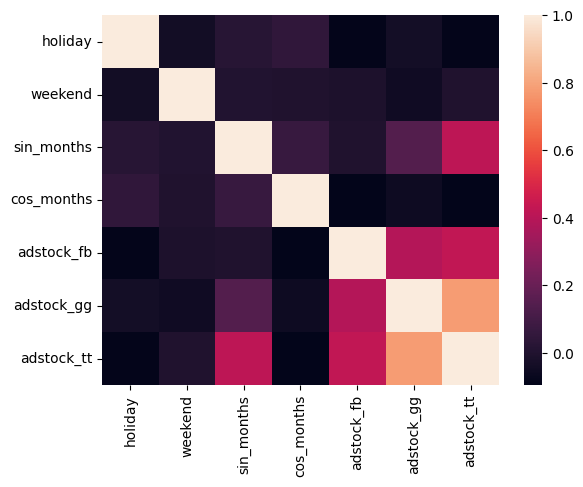

In [1263]:
best_pipeline = random_search.best_estimator_

best_pipeline.fit(train_df, y_train)

pipe_df = pd.DataFrame(best_pipeline[0].transform(train_df))
pipe_df.columns = ['holiday', 'weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']
sns.heatmap(pipe_df.corr());

<module 'matplotlib.pyplot' from '/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/matplotlib/pyplot.py'>

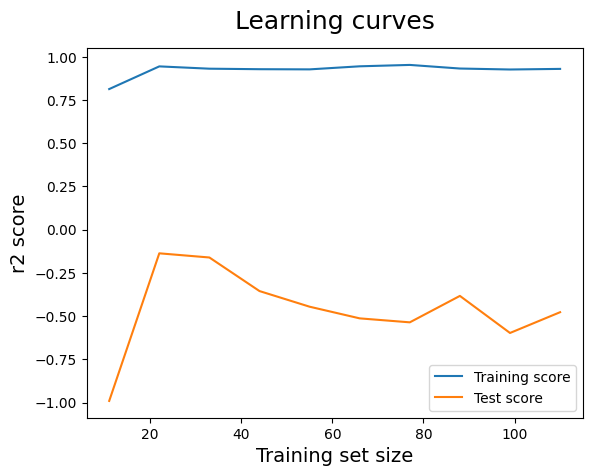

In [1264]:
plot_learning_curve(best_pipeline, 'learning curve', train_df, y_train, cv = tscv)

In [1301]:
best_pipeline = random_search.best_estimator_
random_search.best_params_

{'union__adstock_pipeline__adstock__tiktok_pipe__saturation__shift': 9,
 'union__adstock_pipeline__adstock__tiktok_pipe__saturation__exponent': 0.6,
 'union__adstock_pipeline__adstock__tiktok_pipe__carryover__window': 3,
 'union__adstock_pipeline__adstock__tiktok_pipe__carryover__strength': 0.5,
 'union__adstock_pipeline__adstock__google_pipe__saturation__shift': 9,
 'union__adstock_pipeline__adstock__google_pipe__saturation__exponent': 1.0,
 'union__adstock_pipeline__adstock__google_pipe__carryover__window': 3,
 'union__adstock_pipeline__adstock__google_pipe__carryover__strength': 1.0,
 'union__adstock_pipeline__adstock__facebook_pipe__saturation__shift': 7,
 'union__adstock_pipeline__adstock__facebook_pipe__saturation__exponent': 1.0,
 'union__adstock_pipeline__adstock__facebook_pipe__carryover__window': 1,
 'union__adstock_pipeline__adstock__facebook_pipe__carryover__strength': 0.7000000000000001}

In [1266]:
best_pipeline = random_search.best_estimator_

best_pipeline.fit(train_df, y_train)

pipe_df = pd.DataFrame(best_pipeline[0].transform(train_df))
pipe_df.columns = ['holiday', 'weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']
pipe_df

,holiday,weekend,sin_months,cos_months,adstock_fb,adstock_gg,adstock_tt
0,0.0,0.0,-0.500000,-0.866025,7.444789,1.972837,1.962312
1,0.0,1.0,-0.500000,-0.866025,7.399415,1.934367,1.962312
2,0.0,1.0,-0.500000,-0.866025,7.387679,1.908217,1.962312
3,0.0,0.0,-0.500000,-0.866025,7.451727,1.777849,1.962312
4,0.0,0.0,-0.500000,-0.866025,7.447861,1.827178,1.962312
...,...,...,...,...,...,...,...
650,0.0,0.0,0.866025,-0.500000,9.719972,7.116159,7.113434
651,0.0,0.0,0.866025,-0.500000,9.712954,6.933962,7.111746
652,0.0,1.0,0.866025,-0.500000,9.158109,6.697941,7.125114
653,0.0,1.0,0.866025,-0.500000,8.562553,6.565311,7.183666


In [1267]:
result = permutation_importance(best_pipeline, train_df, y_train)
feature_names = ['holiday', 'weekend', 'sin_months', 'cos_months', 'sales_lag', 'adstock_fb', 'adstock_gg', 'adstock_tt']
feature_names_ = ['orders', 'total_sales', 'facebook', 'google', 'tiktok', 'day', 'trend']

forest_importances = pd.Series(result.importances_mean, index=feature_names_)
forest_importances

orders         0.000000
total_sales    0.000000
facebook       0.520455
google         0.606480
tiktok         0.126148
day            0.000000
trend          0.000000
dtype: float64

In [1268]:
forest = RandomForestRegressor()
forest.fit(pipe_df, y_train)

result = permutation_importance(forest, pipe_df, y_train)
feature_names = ['holiday', 'weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']

forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances

holiday       0.000510
weekend       0.109647
sin_months    0.159066
cos_months    0.021479
adstock_fb    0.489552
adstock_gg    0.604057
adstock_tt    0.225720
dtype: float64

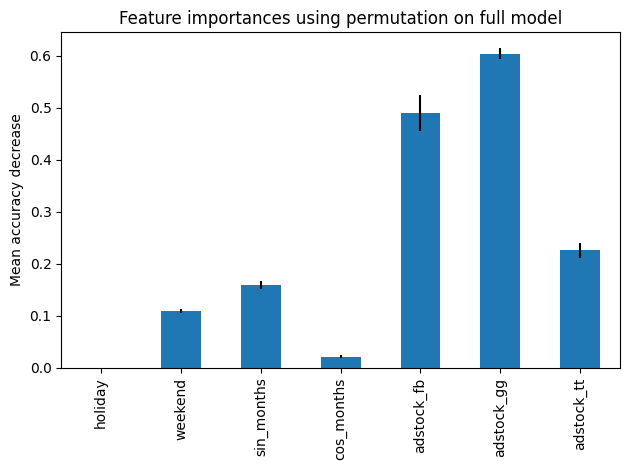

In [1269]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Gradient Boosting

In [1270]:
pipeline = Pipeline([
    ('union', union),
    ('gradient', gradient)
])

tscv = TimeSeriesSplit(n_splits= 5)
cv_results = cross_val_score(pipeline, train_df, y_train, scoring = "r2", cv=tscv).mean()
cv_results

0.11286609727397794

In [1271]:
random_search = RandomizedSearchCV(pipeline, param_grid, cv = tscv)
random_search.fit(train_df, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('union',
                                              FeatureUnion(transformer_list=[('time_preprocessing',
                                                                              Pipeline(steps=[('time_features',
                                                                                               ColumnTransformer(transformers=[('holidays_pipe',
                                                                                                                                Pipeline(steps=[('add_holidays',
                                                                                                                                                 AddHolidaysTransformer())]),
                                                                                                                                ['day']),
                                                                                                                               ('weekends_pipe',
                                                                                                                                Pip...
                                                                                                               0.7000000000000001,
                                                                                                               0.8,
                                                                                                               0.9,
                                                                                                               1.0],
                                        'union__adstock_pipeline__adstock__tiktok_pipe__carryover__window': [1,
                                                                                                             2,
                                                                                                             3,
                                                                                                             4,
                                                                                                             5,
                                                                                                             6,
                                                                                                             7,
                                                                                                             8,
                                                                                                             9,
                                                                                                             10],
                                        'union__adstock_pipeline__adstock__tiktok_pipe__saturation__exponent': [0.1,
                                                                                                                0.2,
                                                                                                                0.30000000000000004,
                                                                                                                0.4,
                                                                                                                0.5,
                                                                                                                0.6,
                                                                                                                0.7000000000000001,
                                                                                                                0.8,
                                                                                                                0.9,
                                                      

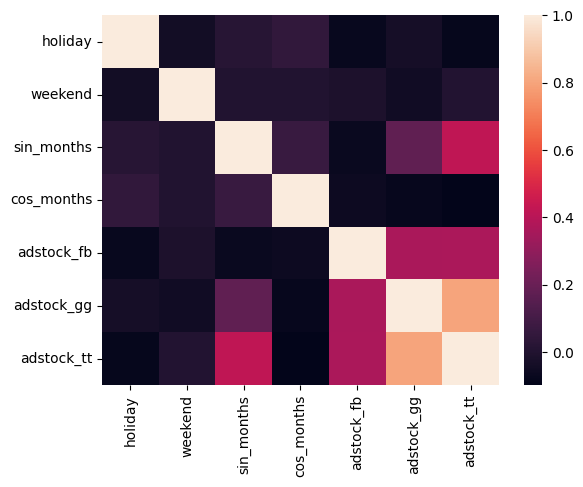

In [1272]:
best_pipeline = random_search.best_estimator_

best_pipeline.fit(train_df, y_train)

pipe_df = pd.DataFrame(best_pipeline[0].transform(train_df))
pipe_df.columns = ['holiday', 'weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']
sns.heatmap(pipe_df.corr());

In [1273]:
best_pipeline.fit(train_df, y_train)

y_true = test_df['total_sales']
y_pred = best_pipeline.predict(test_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(test_df, y_test)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: -0.023750830621207975, MAE: 1776.27181143238, RMSE: 2676.229599023863'

## SVM

In [1274]:
"""pipeline = Pipeline([
    ('union', union),
    ('svm', svm)
])

tscv = TimeSeriesSplit(n_splits= 5)
cv_results = cross_val_score(pipeline, train_df, y_train, scoring = "r2", cv=tscv).mean()
cv_results"""

'pipeline = Pipeline([\n    (\'union\', union),\n    (\'svm\', svm)\n])\n\ntscv = TimeSeriesSplit(n_splits= 5)\ncv_results = cross_val_score(pipeline, train_df, y_train, scoring = "r2", cv=tscv).mean()\ncv_results'

## Check pipeline output

In [1275]:
pipeline = Pipeline([
    ('union', union),
    ('lin_reg', lin_reg)
])

tscv = TimeSeriesSplit(n_splits= 3)
random_search = RandomizedSearchCV(pipeline, param_grid, cv = tscv)
random_search.fit(train_df, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('union',
                                              FeatureUnion(transformer_list=[('time_preprocessing',
                                                                              Pipeline(steps=[('time_features',
                                                                                               ColumnTransformer(transformers=[('holidays_pipe',
                                                                                                                                Pipeline(steps=[('add_holidays',
                                                                                                                                                 AddHolidaysTransformer())]),
                                                                                                                                ['day']),
                                                                                                                               ('weekends_pipe',
                                                                                                                                Pip...
                                                                                                               0.7000000000000001,
                                                                                                               0.8,
                                                                                                               0.9,
                                                                                                               1.0],
                                        'union__adstock_pipeline__adstock__tiktok_pipe__carryover__window': [1,
                                                                                                             2,
                                                                                                             3,
                                                                                                             4,
                                                                                                             5,
                                                                                                             6,
                                                                                                             7,
                                                                                                             8,
                                                                                                             9,
                                                                                                             10],
                                        'union__adstock_pipeline__adstock__tiktok_pipe__saturation__exponent': [0.1,
                                                                                                                0.2,
                                                                                                                0.30000000000000004,
                                                                                                                0.4,
                                                                                                                0.5,
                                                                                                                0.6,
                                                                                                                0.7000000000000001,
                                                                                                                0.8,
                                                                                                                0.9,
                                                      

In [1276]:
f"Best Parameters: {random_search.best_params_}"

"Best Parameters: {'union__adstock_pipeline__adstock__tiktok_pipe__saturation__shift': 6, 'union__adstock_pipeline__adstock__tiktok_pipe__saturation__exponent': 0.8, 'union__adstock_pipeline__adstock__tiktok_pipe__carryover__window': 6, 'union__adstock_pipeline__adstock__tiktok_pipe__carryover__strength': 0.1, 'union__adstock_pipeline__adstock__google_pipe__saturation__shift': 7, 'union__adstock_pipeline__adstock__google_pipe__saturation__exponent': 0.1, 'union__adstock_pipeline__adstock__google_pipe__carryover__window': 6, 'union__adstock_pipeline__adstock__google_pipe__carryover__strength': 0.8, 'union__adstock_pipeline__adstock__facebook_pipe__saturation__shift': 2, 'union__adstock_pipeline__adstock__facebook_pipe__saturation__exponent': 1.0, 'union__adstock_pipeline__adstock__facebook_pipe__carryover__window': 7, 'union__adstock_pipeline__adstock__facebook_pipe__carryover__strength': 0.30000000000000004}"

In [1277]:
train_df

,orders,total_sales,facebook,google,tiktok,day,trend
Day,,,,,,,
2021-07-01,10,414.85,257.01,1.17,0.00,2021-07-01,0
2021-07-02,6,229.95,250.30,0.84,0.00,2021-07-02,1
2021-07-03,10,459.89,248.59,0.72,0.00,2021-07-03,2
2021-07-04,17,508.36,258.05,0.07,0.00,2021-07-04,3
2021-07-05,13,399.88,257.47,0.38,0.00,2021-07-05,4
...,...,...,...,...,...,...,...
2023-04-12,83,3718.12,885.33,208.52,209.03,2023-04-12,650
2023-04-13,75,2913.63,882.17,186.47,208.82,2023-04-13,651
2023-04-14,53,1735.46,662.08,160.69,216.38,2023-04-14,652


In [1278]:
# Check pipeline output as a pandas DataFrame
best_pipeline = random_search.best_estimator_

best_pipeline.fit(train_df, y_train)

pipe_df = pd.DataFrame(best_pipeline[0].transform(train_df))
pipe_df.columns = ['holiday', 'weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']
pipe_df

,holiday,weekend,sin_months,cos_months,adstock_fb,adstock_gg,adstock_tt
0,0.0,0.0,-0.500000,-0.866025,180.946354,2.202087,3.991203
1,0.0,1.0,-0.500000,-0.866025,230.232233,2.229206,3.991203
2,0.0,1.0,-0.500000,-0.866025,243.820735,2.245274,3.991203
3,0.0,0.0,-0.500000,-0.866025,254.520734,2.229500,3.991203
4,0.0,0.0,-0.500000,-0.866025,257.324645,2.230539,3.991203
...,...,...,...,...,...,...,...
650,0.0,0.0,0.866025,-0.500000,882.745742,7.450876,90.582570
651,0.0,0.0,0.866025,-0.500000,883.083257,7.262256,90.501340
652,0.0,1.0,0.866025,-0.500000,729.092582,7.100614,92.810554
653,0.0,1.0,0.866025,-0.500000,556.631060,6.913892,100.082554


## Check for collinearity

### Heatmap

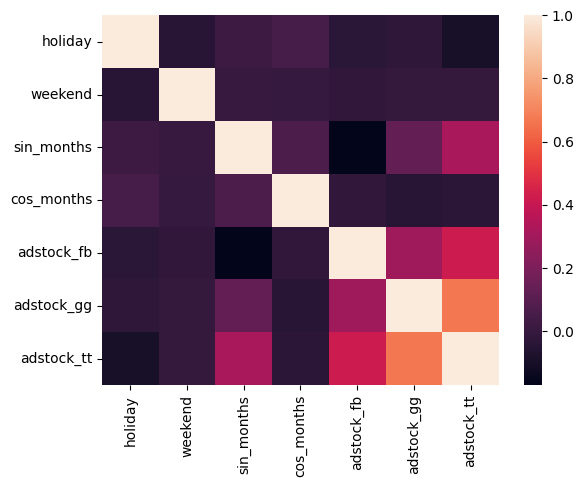

In [1279]:
sns.heatmap(pipe_df.corr());

### VIF

In [1280]:
# VIF dataframe
vif_data = pd.DataFrame()

pipe_df = pd.DataFrame(best_pipeline[0].transform(train_df))
pipe_df.columns = ['holiday','weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']

vif_data["feature"] = pipe_df.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(pipe_df.values, i)
                          for i in range(len(pipe_df.columns))]
  
print(vif_data)

      feature       VIF
0     holiday  1.053925
1     weekend  1.330039
2  sin_months  1.298789
3  cos_months  1.024008
4  adstock_fb  3.821566
5  adstock_gg  5.897432
6  adstock_tt  5.373757


In [1281]:
# VIF dataframe
vif_data = pd.DataFrame()

pipe_df = pd.DataFrame(best_pipeline[0].transform(train_df))
pipe_df.columns = ['holiday','weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']


vif_data["feature"] = pipe_df.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(pipe_df.values, i)
                          for i in range(len(pipe_df.columns))]
  
print(vif_data)

      feature       VIF
0     holiday  1.053925
1     weekend  1.330039
2  sin_months  1.298789
3  cos_months  1.024008
4  adstock_fb  3.821566
5  adstock_gg  5.897432
6  adstock_tt  5.373757


In [1282]:
def plot_learning_curve(estimator, title, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=tscv, train_sizes=train_sizes, scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, label = 'Test score')
    plt.ylabel('r2 score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()
    
    return plt

<module 'matplotlib.pyplot' from '/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/matplotlib/pyplot.py'>

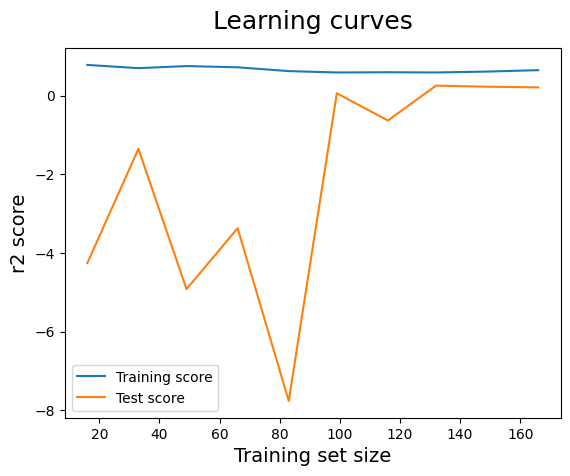

In [1283]:
plot_learning_curve(best_pipeline, 'learning curve', train_df, y_train, cv = tscv)

In [1284]:
"""def adj_r2():
    r2 = 
    1-(1-R2)*(n-1)/(n-p-1)"""

'def adj_r2():\n    r2 = \n    1-(1-R2)*(n-1)/(n-p-1)'

## Fit and Score on Test

#### Test data

##### Pipeline - Default Hyperparameters

In [1307]:
pipeline = Pipeline([
    ('union', union),
    ('lin_reg', lin_reg)
])

pipeline.fit(train_df, y_train)

y_true = test_df['total_sales']
y_pred = pipeline.predict(test_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {pipeline.score(test_df, y_test)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.3380034349328809, MAE: 1404.7151998838478, RMSE: 2152.058655634907'

In [1309]:
lin_reg.coef_

array([-164.05296127, -372.68612697,  265.07669913,  -23.34180812,
          1.14417865,    5.50411718,    1.48381395])

In [1310]:
# Check pipeline output as a pandas DataFrame
pipeline.fit(train_df, y_train)

pipe_df = pd.DataFrame(best_pipeline[0].transform(train_df))
pipe_df.columns = ['holiday', 'weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']
pipe_df

,holiday,weekend,sin_months,cos_months,adstock_fb,adstock_gg,adstock_tt
0,0.0,0.0,-0.500000,-0.866025,263.01,8.390000,4.561988
1,0.0,1.0,-0.500000,-0.866025,256.30,8.670000,4.561988
2,0.0,1.0,-0.500000,-0.866025,254.59,8.910000,4.561988
3,0.0,0.0,-0.500000,-0.866025,264.05,8.543333,4.561988
4,0.0,0.0,-0.500000,-0.866025,263.47,8.390000,4.561988
...,...,...,...,...,...,...,...
650,0.0,0.0,0.866025,-0.500000,891.33,238.840000,40.525140
651,0.0,0.0,0.866025,-0.500000,888.17,215.730000,40.493152
652,0.0,1.0,0.866025,-0.500000,668.08,193.226667,40.977536
653,0.0,1.0,0.866025,-0.500000,487.71,173.440000,42.730318


In [1312]:
lin_reg = LinearRegression()
lin_reg.fit(pipe_df, y_train)

result = permutation_importance(lin_reg, pipe_df, y_train)
feature_names = ['holiday', 'weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']

forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances

holiday       0.001652
weekend       0.047385
sin_months    0.040233
cos_months    0.000023
adstock_fb    0.328238
adstock_gg    0.264208
adstock_tt    0.099385
dtype: float64

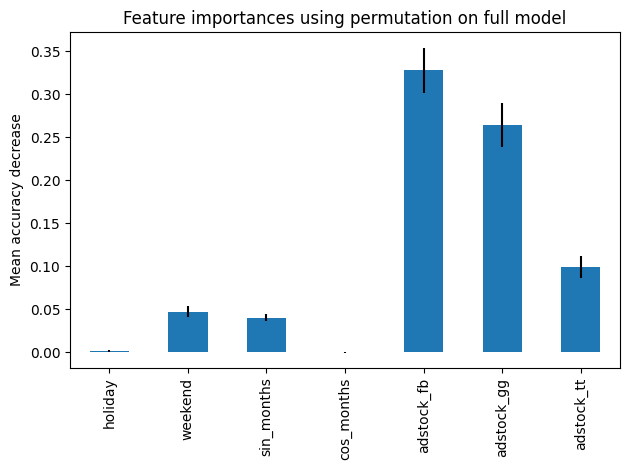

In [1313]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

##### Pipeline - Optimized Hyperparameters

In [1292]:
pipeline = Pipeline([
    ('union', union),
    ('lin_reg', lin_reg)
])

random_search = RandomizedSearchCV(pipeline, param_grid, cv = tscv)
random_search.fit(train_df, y_train)

best_pipeline.fit(train_df, y_train)

best_pipeline = random_search.best_estimator_

best_pipeline.fit(train_df, y_train)

y_true = test_df['total_sales']
y_pred = best_pipeline.predict(test_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(test_df, y_test)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.1762287808493045, MAE: 1590.4917243360635, RMSE: 2400.653848226497'

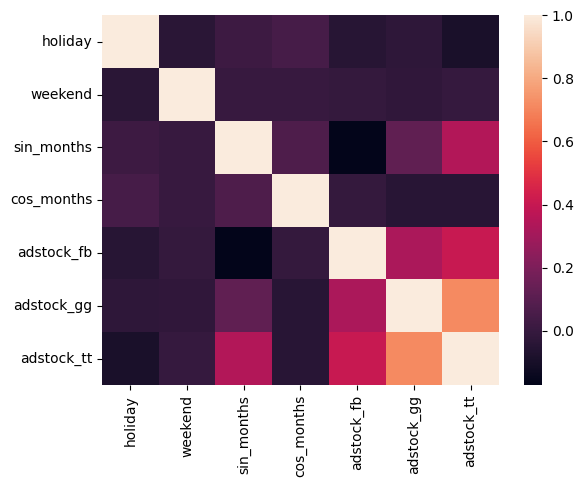

In [1287]:
pipe_df = pd.DataFrame(best_pipeline[0].transform(train_df))
pipe_df.columns = ['holiday', 'weekend', 'sin_months', 'cos_months', 'adstock_fb', 'adstock_gg', 'adstock_tt']
sns.heatmap(pipe_df.corr());

In [1288]:
min = train_df['total_sales'].min()
max = train_df['total_sales'].max()
f"Range: min: {min}, max: {max}"

'Range: min: -69.99, max: 9803.01'

#### Train data

##### Pipeline - Default Hyperparameters

In [1289]:
pipeline.fit(train_df, y_train)

y_true = train_df['total_sales']
y_pred = pipeline.predict(train_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {pipeline.score(train_df, y_train)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.6902204114578927, MAE: 447.76901557739745, RMSE: 715.087653408595'

##### Pipeline - Optimized Hyperparameters

In [1290]:
best_pipeline.fit(train_df, y_train)

y_true = train_df['total_sales']
y_pred = best_pipeline.predict(train_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(train_df, y_train)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.6522841497164511, MAE: 496.2484763209419, RMSE: 757.6089985037823'